In [2]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames


  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [3]:
innovations = CSV.File("./data/innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data/map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data/compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data/initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations[2,6]=7
compromise[!,3]=compromise[!,3]/2
innovations[2,2]=175
innovations[2,3]=2
innovations[1,3]=3
innovations[4,2]=168
#innovations[3,3]=2
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,3,4.6,1.34,2.04,0.12,8.86,0
2,2,175,2,8.32,8.84,0.65,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,168,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [5]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,40.0,0.6,0.5,0.0
2,2,1,43.0,0.66,0.55,0.0
3,3,1,45.5,0.68,0.567,0.0
4,4,1,47.5,0.7,0.583,0.0
5,5,2,30.0,0.4,0.0,0.2
6,6,2,32.0,0.48,0.0,0.24
7,7,2,34.0,0.5,0.0,0.27
8,8,2,38.0,0.52,0.0,0.34
9,9,2,40.0,0.54,0.0,0.37


In [6]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


give_sorted (generic function with 1 method)

## Additional functions

In [8]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

function get_latest(i,t)
    e0=zeros(5,1,i)
    e1=zeros(5,5,i)
    e2=zeros(5,5,i)
    e3=zeros(1,5,i)
    for r in 1:5
        e0[r,1,i]=exp(d[r,1,i]*t)
    end

    for r in 1:5
        for c in 1:5
            e1[r,c,i]=e0[r,1,i]*ainv[r,c,i]
        end
    end

    for r in 1:5
        for c in 1:5
            e2[r,c,i]=sum(a[r,c1,i]*e1[c1,c,i] for c1 in 1:5)
        end
    end

    for c in 1:5
        e3[1,c,i]=sum(s0[1,r,i]*e2[r,c,i] for r in 1:5)
    end


    e4=sum(rl_vals[c]*e3[1,c,i] for c in 1:5)

    #rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'
    return 5-e4
end

get_latest(1,50)
#rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'

0.3742059960635462

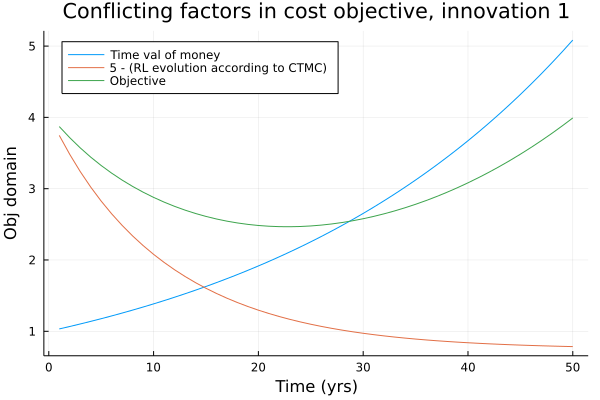

In [9]:
inn=3
plot(range(1, 50; length = 50),[0.968^(-1*i) for i = 1:50],labels="Time val of money")
plot!(range(1, 50; length = 50), [get_latest.(inn,1:50)],labels="5 - (RL evolution according to CTMC)")
plot_ref=plot!(range(1, 50; length = 50), [0.968^(-1*i)*get_latest.(inn,i) for i = 1:50], labels="Objective",legend=:topleft,
        xlab="Time (yrs)", ylab="Obj domain", title="Conflicting factors in cost objective, innovation 1")
#savefig(plot_ref,"evolution-inn_costObj.svg")

In [10]:
intvls=40
fval=zeros(intvls+1,5)
tval=zeros(intvls+1,5)
for inn in 1:5
    tval[:,inn]=[i*(50/intvls) for i = 0:intvls]
    fval[:,inn]=[0.968^(-1*i*(50/intvls))*get_latest.(inn,i*(50/intvls)) for i =0:intvls]
end
[tval[:,1] fval]

41×6 Matrix{Float64}:
  0.0   1.99304  2.9877   4.03842  1.97829  3.99762
  1.25  1.74797  3.0479   3.83095  1.95276  3.99894
  2.5   1.56345  3.09335  3.64195  1.92998  3.99786
  3.75  1.43071  3.13236  3.47374  1.91524  3.99623
  5.0   1.33152  3.16732  3.32463  1.91046  3.99522
  6.25  1.25508  3.19957  3.19233  1.91583  3.99557
  7.5   1.19476  3.2301   3.0748   1.93071  3.99783
  8.75  1.14639  3.25971  2.97042  1.95419  4.00245
 10.0   1.10731  3.28907  2.87796  1.98531  4.00977
 11.25  1.07574  3.31874  2.79644  2.02319  4.02012
 12.5   1.0505   3.34918  2.72513  2.06709  4.03377
 13.75  1.03075  3.3808   2.66342  2.11645  4.05099
 15.0   1.01591  3.41393  2.61081  2.17081  4.07201
  ⋮                                         ⋮
 36.25  1.28835  4.41637  2.84703  3.78991  5.2083
 37.5   1.32993  4.511    2.9192   3.9318   5.33226
 38.75  1.37423  4.6107   2.99753  4.08007  5.46395
 40.0   1.42127  4.71566  3.08208  4.23497  5.60362
 41.25  1.47109  4.82609  3.17289  4.39675  5.751

In [11]:
#CSV.write("./data/cost_inn_obj.csv",  Tables.table([tval[:,1] fval]), writeheader=true)


In [13]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.0815477  0.1365     0.0131513   0.447524  0.321277
 0.0712625  0.120257   0.0124373   0.459736  0.336307
 0.0461925  0.0796249  0.0106524   0.489744  0.373786
 0.0323738  0.0573037  0.00967175  0.506267  0.394383
 0.0299688  0.0534099  0.00949941  0.509059  0.398063

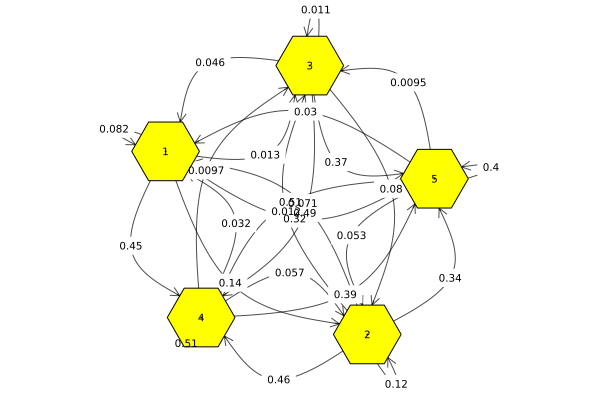

In [14]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)